# Формализация задачи и EDA
* Правильно настроенные рекомендательные системы могут увеличить средний чек покупки, что повышает прибыль маркетплейса.
* Рекомендация нужных товаров способствует улучшению пользовательского опыта с нашим продуктом, что будет мотивировать его приходить чаще.
* Снижение затрат на маркетинг и общее увеличение эффективности маркетинговых компаний за счет правильно настроенной рекомендательной системы.


### Цели на текущий этап проекта:
* Провести разведочный анализ
* Проанализировать исходные данные и оценить их пригодность, выявить аномалии и выбросы
* Подготовить данные для будущих этапов работы

Импортируем необходимые для работы библиотеки:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as plt
import seaborn as sns

Подгружаем и выводим данные:

In [2]:
wb_data = pd.read_csv("wb_school_task_1.csv")
wb_data.head()

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09.000000
1,571051,580,2023-01-01 00:41:47.000000
2,571051,180,2023-01-01 00:41:47.000000
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000


Проверяем наличие нулевых значений:

In [3]:
print(wb_data.isnull().sum())

user_id     0
item_id     0
order_ts    0
dtype: int64


Проверяем количество уникальных пользователей и товаров:

In [4]:
print(len(wb_data['user_id'].unique()))
print(len(wb_data['item_id'].unique()))

1057265
6562


Анализ сезонности покупок товаров

In [6]:
# Преобразуем столбец order_date в формат даты
wb_data['order_date'] = pd.to_datetime(wb_data['order_ts'])

# Добавляем столбец с днем недели
wb_data['day_of_week'] = wb_data['order_ts'].dt.day_name()

# Группируем данные по дню недели и считаем количество уникальных пользователей и товаров
daily_orders = wb_data.groupby('day_of_week').agg({'user_id': 'nunique', 'item_id': 'count'}).reset_index()
daily_orders.columns = ['День недели', 'Количество пользователей', 'Количество товаров']

print(daily_orders)

AttributeError: Can only use .dt accessor with datetimelike values

In [7]:
wb_data['order_ts'] = pd.to_datetime(wb_data['order_ts'])

wb_data['month_day'] = wb_data['order_date'].apply(lambda x: f"{x.month:02d}-{x.day:02d}")
# Группируем данные по дню месяца и месяцу и считаем количество уникальных пользователей и товаров
monthly_orders = wb_data.groupby(['month_day']).agg({'user_id': 'nunique', 'item_id': 'count'}).reset_index()
monthly_orders.columns = ['Месяц-День', 'Количество пользователей', 'Количество товаров']

print(monthly_orders)

   Месяц-День  Количество пользователей  Количество товаров
0       01-01                     59947              122484
1       01-02                     72807              150109
2       01-03                     73391              149883
3       01-04                     76061              154834
4       01-05                     80304              165672
..        ...                       ...                 ...
85      03-27                    115854              249288
86      03-28                    114611              245793
87      03-29                    114948              247284
88      03-30                    113512              244308
89      03-31                    107219              230654

[90 rows x 3 columns]


C:\Users\Иван\AppData\Local\Temp\ipykernel_11328\1297124787.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Месяц-День', y='Количество пользователей', data=monthly_orders, palette='viridis')


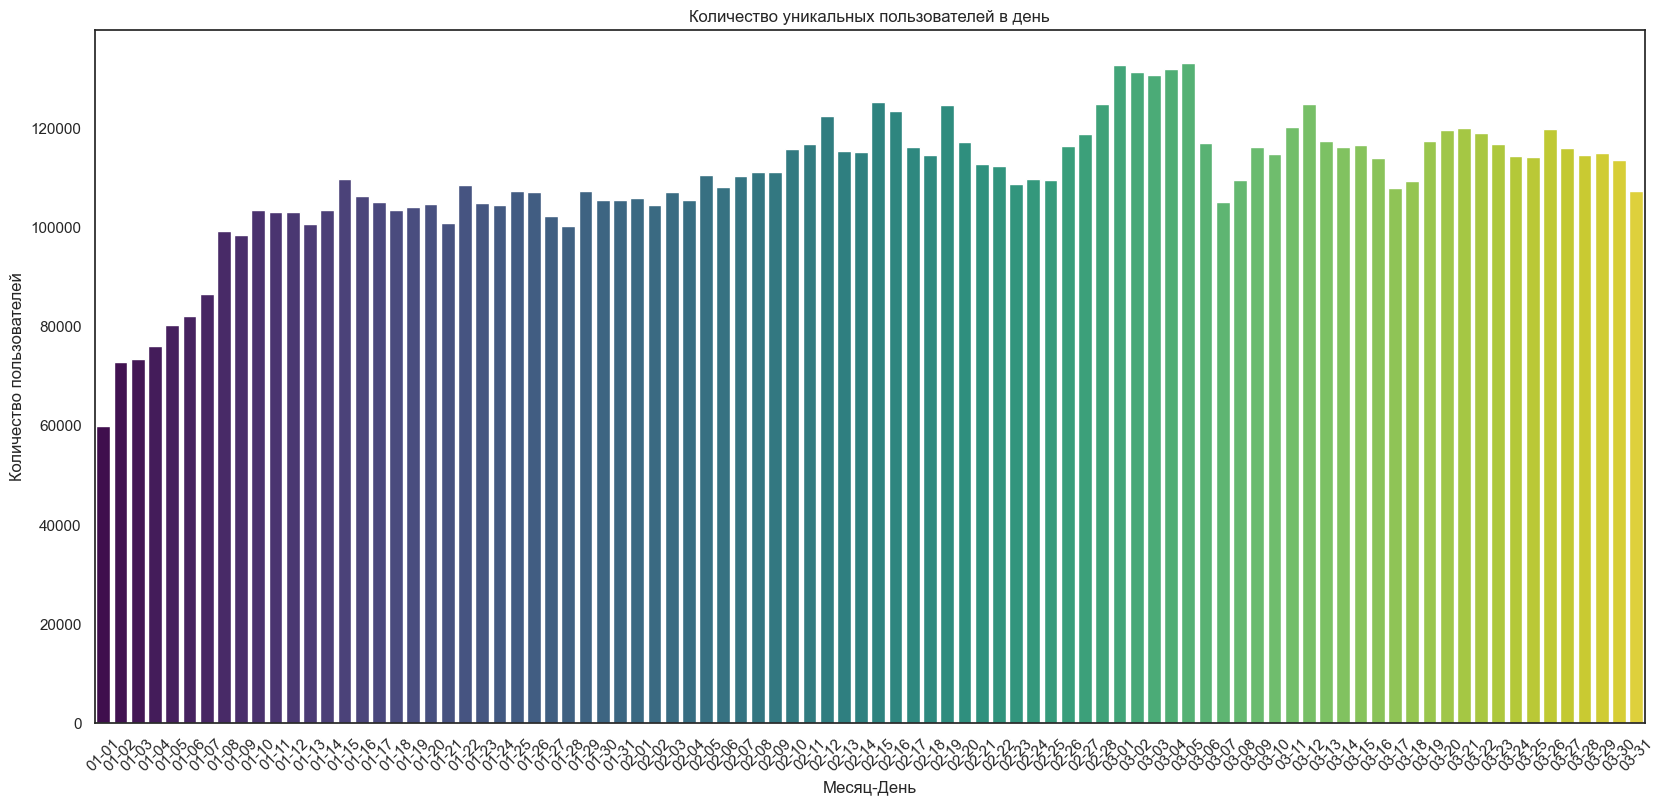

In [ ]:
plt.figure(figsize=(20, 9))
sns.barplot(x='Месяц-День', y='Количество пользователей', data=monthly_orders, palette='viridis')
plt.title('Количество уникальных пользователей в день')
plt.xticks(rotation=45)
plt.show()


C:\Users\Иван\AppData\Local\Temp\ipykernel_11328\1949882815.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Месяц-День', y='Количество товаров', data=monthly_orders, palette='viridis')


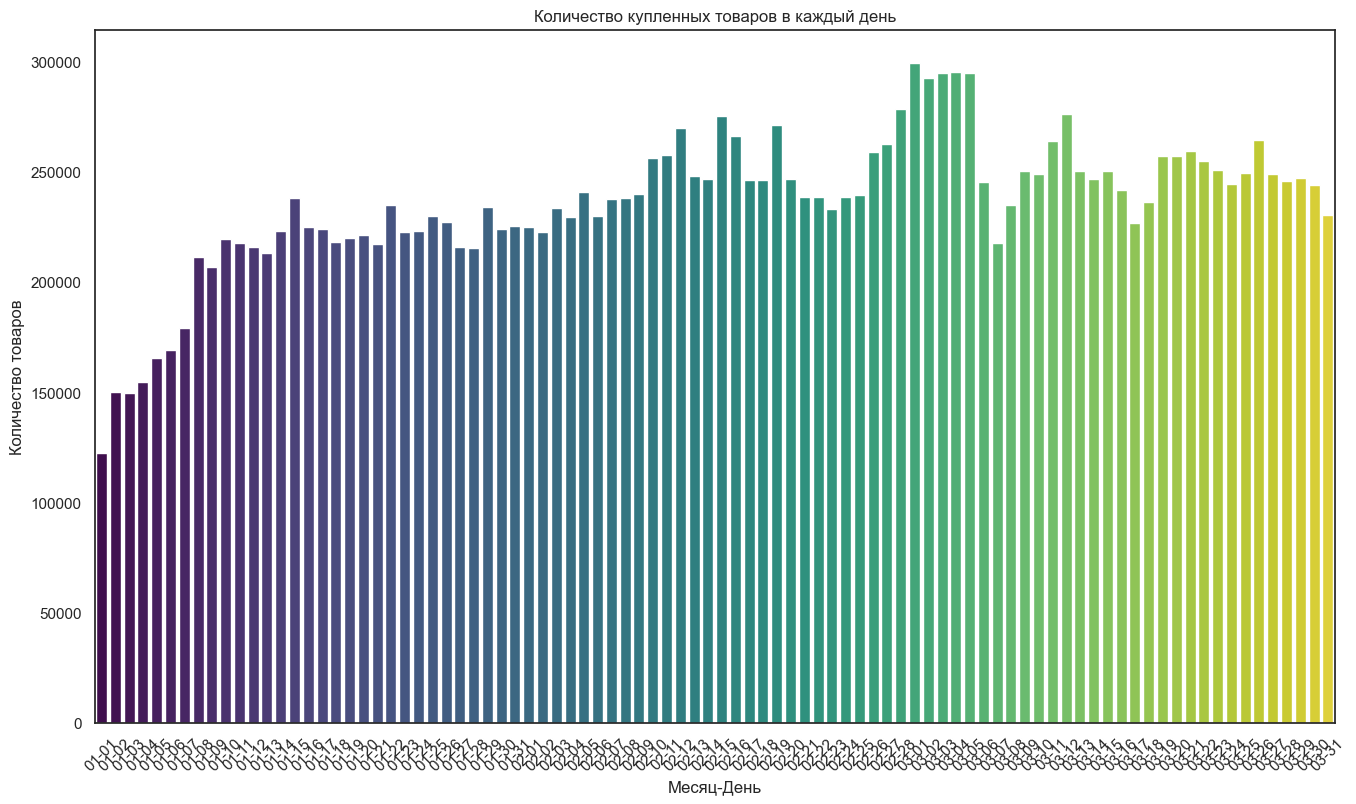

In [ ]:

plt.figure(figsize=(16, 9))
sns.barplot(x='Месяц-День', y='Количество товаров', data=monthly_orders, palette='viridis')
plt.title('Количество купленных товаров в каждый день')
plt.xticks(rotation=45)
plt.show()


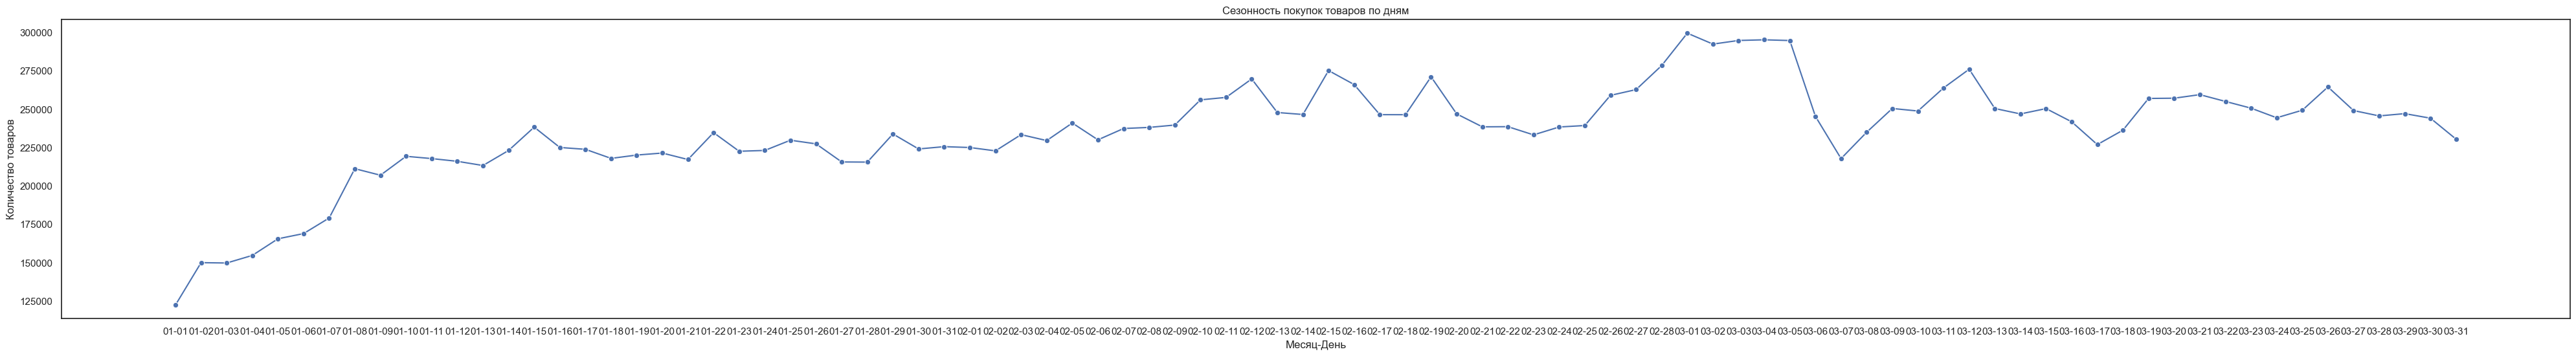

In [ ]:
plt.figure(figsize=(50, 6))
sns.lineplot(x='Месяц-День', y='Количество товаров', data=monthly_orders, marker='o')
plt.title('Сезонность покупок товаров по дням')
plt.show()

Промежуточные выводы:
* Имеем дело с неявным фидбеком (Implicit), нет рейтинга и других качественных параметров -> связь достаточно шумная
* Из графика видим: есть оптовики, покупающие несколько сотен товаров, есть неактивные юзеры, покупающие мало товаров -> будем отсеивать юзеров по количеству купленных товаров
* Отсутствие качественных признаков -> будем использовать дату для генерации фичей (увидели что по выходным люди чаще покупают)

Теперь попытаемся убрать тех юзеров, кто заказывает реже чем каждый месяц, получилось сократить выборку в два раза

In [8]:
# Преобразование столбца с временем заказа в формат datetime
#wb_data['order_ts'] = pd.to_datetime(wb_data['order_ts'])

# Извлечение месяца из времени заказа
wb_data['month'] = wb_data['order_ts'].dt.month

# Группировка по пользователю и подсчет количества уникальных месяцев покупок
user_purchase_frequency = wb_data.groupby('user_id')['month'].nunique()

# Отфильтровываем пользователей, у которых покупки реже чем раз в 3 месяца
active_users = user_purchase_frequency[user_purchase_frequency >= 3].index

# Фильтрация исходного DataFrame по активным пользователям
df_filtered = wb_data[wb_data['user_id'].isin(active_users)]

# Группировка по пользователю, месяцу и подсчет количества заказанных товаров
items_per_user = df_filtered.groupby(['user_id', 'month']).size().reset_index(name='num_items_bought')

print(items_per_user)


         user_id  month  num_items_bought
0              3      1                 7
1              3      2                14
2              3      3                22
3             15      1                 7
4             15      2                 4
...          ...    ...               ...
1624237  1057263      2                 9
1624238  1057263      3                19
1624239  1057265      1                 4
1624240  1057265      2                 1
1624241  1057265      3                 7

[1624242 rows x 3 columns]


In [9]:
print(items_per_user["num_items_bought"].mean())

11.183354450876163


Оставшиеся юзеры в среднем заказывают 11 товаров в месяц. Ограничим количество заказов от 3 до 100 в месяц, чтобы убрать не активных юзеров и оптовиков

In [20]:

#items_per_user_filtered = items_per_user[items_per_user['num_items_bought'] <= 30]
items = items_per_user[(items_per_user['num_items_bought'] >= 5) & (items_per_user['num_items_bought'] <= 50)]

# Группировка по пользователю и подсчет количества уникальных месяцев покупок
user_purchase_frequency = items.groupby('user_id')['month'].nunique()

# Отфильтровываем пользователей, у которых покупки реже чем раз в 3 месяца
active_users = user_purchase_frequency[user_purchase_frequency >= 3].index

items_res = items[items['user_id'].isin(active_users)]
print(items_res)

         user_id  month  num_items_bought
0              3      1                 7
1              3      2                14
2              3      3                22
6             16      1                 6
7             16      2                15
...          ...    ...               ...
1624222  1057256      2                 7
1624223  1057256      3                 6
1624236  1057263      1                13
1624237  1057263      2                 9
1624238  1057263      3                19

[684570 rows x 3 columns]


Определим количество уникальных юзеров после введенных ограничений:

In [21]:
n = len(pd.unique(items_res['user_id']))

print("Количество пользователей, покупающих каждый месяц от 8 до 11 товаров :",n)

Количество пользователей, покупающих каждый месяц от 8 до 11 товаров : 228190


Сформируем список из user_id для фильтрации исходного датасета:

In [22]:
usefull_users = items_res['user_id'].unique().tolist()
print(usefull_users)
print(len(usefull_users))

[3, 16, 29, 34, 35, 37, 44, 68, 69, 70, 71, 73, 92, 93, 98, 99, 102, 106, 109, 115, 129, 130, 139, 143, 145, 146, 149, 153, 155, 173, 175, 182, 183, 187, 190, 193, 195, 202, 206, 211, 212, 220, 221, 228, 230, 231, 239, 242, 248, 252, 254, 255, 256, 273, 276, 279, 280, 285, 286, 291, 296, 318, 320, 321, 327, 332, 333, 342, 345, 356, 369, 370, 371, 376, 379, 382, 388, 390, 391, 397, 405, 406, 417, 422, 424, 427, 438, 439, 440, 453, 461, 465, 474, 476, 478, 483, 488, 495, 498, 501, 503, 505, 506, 508, 510, 516, 520, 529, 532, 535, 536, 544, 548, 549, 553, 559, 561, 573, 574, 576, 583, 592, 604, 608, 614, 619, 634, 636, 646, 647, 669, 678, 684, 685, 691, 693, 701, 704, 707, 708, 717, 720, 727, 736, 737, 742, 744, 745, 746, 747, 751, 753, 755, 762, 768, 787, 791, 802, 805, 810, 811, 815, 819, 825, 829, 832, 834, 838, 848, 849, 853, 858, 859, 861, 863, 877, 878, 879, 888, 899, 900, 902, 903, 905, 906, 912, 917, 920, 932, 934, 942, 945, 947, 953, 958, 959, 963, 971, 973, 974, 978, 979, 988, 9

Фильтруем данные и добавляем столбец с номером месяца и дня заказа:

In [23]:
df = wb_data[wb_data['user_id'].isin(usefull_users)]
# Добавляем столбец с днями месяца
df['day_of_month'] = df['order_ts'].dt.day
print(df)

          user_id  item_id                   order_ts  \
0          550614      264 2023-01-01 00:28:09.000000   
3           47164     5135 2023-01-01 00:53:35.000000   
6          124741      437 2023-01-01 01:15:03.000000   
8          757324      721 2023-01-01 01:46:57.000000   
10         462564      286 2023-01-01 01:53:13.000000   
...           ...      ...                        ...   
21265779   249269      348 2023-03-31 23:55:37.182803   
21265780   373951     3835 2023-03-31 23:59:24.148327   
21265781   505474     1340 2023-03-31 23:59:24.161567   
21265782  1011023      153 2023-03-31 23:59:38.371329   
21265783   756570     6623 2023-03-31 23:59:51.669277   

                         order_date month_day  month  day_of_month  
0        2023-01-01 00:28:09.000000     01-01      1             1  
3        2023-01-01 00:53:35.000000     01-01      1             1  
6        2023-01-01 01:15:03.000000     01-01      1             1  
8        2023-01-01 01:46:57.000000    

C:\Users\Иван\AppData\Local\Temp\ipykernel_13676\3278713420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_month'] = df['order_ts'].dt.day


Проверим количество уникальных товаров, оставшихся в выборке:

In [24]:
n = len(pd.unique(df['item_id']))

print("Количество уникальных товаров, купленных выбранными юзерами:", n , "Количество товаров в исходной выборке: ", len(wb_data['item_id'].unique()))

Количество уникальных товаров, купленных выбранными юзерами: 6339 Количество товаров в исходной выборке:  6562


Составим новый дата фрейм, включающий пользователей и их заказы в списке:

In [25]:
# Группируем данные по user_id
grouped_df = df.groupby('user_id')

# Применяем функцию к каждой группе, чтобы получить список item_id
new_df1 = grouped_df.apply(lambda x: x['item_id'].tolist()).reset_index(name='list_items')

print(new_df1)



        user_id                                         list_items
0             3  [363, 3835, 41, 11, 165, 149, 611, 11, 11, 477...
1            16  [3637, 104, 1834, 105, 104, 104, 133, 133, 133...
2            29  [1109, 2171, 157, 451, 1248, 1248, 451, 999, 3...
3            34  [1939, 1069, 1069, 667, 5346, 871, 838, 787, 3...
4            35  [812, 159, 203, 213, 5116, 1594, 184, 217, 99,...
...         ...                                                ...
228185  1057241  [5136, 191, 1076, 347, 357, 344, 150, 52, 41, ...
228186  1057242  [2567, 1571, 717, 2576, 363, 212, 594, 358, 36...
228187  1057245  [358, 1853, 4943, 447, 50, 1352, 593, 4943, 12...
228188  1057256  [342, 4753, 342, 541, 4378, 105, 336, 440, 317...
228189  1057263  [4556, 721, 69, 457, 215, 4088, 855, 4088, 115...

[228190 rows x 2 columns]


Сделаем ещё один дата фрейм, содержащий пользователей и номера дней, в которые выполнен заказ в виде списка:

In [ ]:
# Группируем данные по user_id
grouped_df = df.groupby('user_id')

# Применяем функцию к каждой группе, чтобы получить список дней заказов
new_df2 = grouped_df.apply(lambda x: x['order_ts'].dt.day.tolist()).reset_index(name='list_days')

print(new_df2)



        user_id                                          list_days
0             3  [30, 30, 30, 30, 30, 30, 30, 2, 2, 27, 3, 5, 5...
1            15  [8, 11, 21, 21, 21, 6, 29, 29, 5, 18, 19, 12, ...
2            16  [1, 14, 4, 10, 14, 17, 2, 27, 27, 21, 23, 1, 4...
3            25  [8, 16, 18, 23, 13, 8, 13, 16, 5, 8, 8, 8, 8, ...
4            26  [21, 16, 16, 16, 16, 16, 7, 13, 24, 24, 24, 24...
...         ...                                                ...
349058  1057247  [8, 8, 8, 14, 11, 11, 24, 23, 23, 23, 24, 23, ...
349059  1057250  [13, 16, 6, 7, 8, 6, 11, 15, 2, 26, 26, 16, 13...
349060  1057256  [11, 11, 11, 16, 16, 20, 24, 1, 1, 1, 1, 21, 2...
349061  1057258  [8, 8, 8, 8, 26, 6, 6, 6, 6, 10, 26, 31, 21, 2...
349062  1057263  [4, 13, 5, 4, 5, 4, 8, 4, 12, 13, 13, 19, 26, ...

[349063 rows x 2 columns]


Замерджим два этих фрейма и получим обработанный датасет содержащий в себе id пользователя, список покупок для каждого из них и номера дней, в которые совершались покупки. В качестве гипотезы можно предположить что день покупки имеют некоторую системность для определенных пользователей, зависящую например от выдачи зарплаты или иных выплат.

In [ ]:
data = pd.merge(new_df1,new_df2, on='user_id')
print(data)

        user_id                                         list_items  \
0             3  [363, 3835, 41, 11, 165, 149, 611, 11, 11, 477...   
1            15  [3323, 5589, 593, 2913, 1955, 1489, 3675, 3674...   
2            16  [3637, 104, 1834, 105, 104, 104, 133, 133, 133...   
3            25  [2326, 363, 792, 8098, 69, 2135, 11, 385, 358,...   
4            26  [439, 38, 192, 69, 233, 38, 4341, 362, 165, 41...   
...         ...                                                ...   
349058  1057247  [1321, 593, 788, 814, 814, 1411, 1321, 227, 38...   
349059  1057250  [859, 381, 93, 3416, 94, 215, 832, 2620, 11, 9...   
349060  1057256  [342, 4753, 342, 541, 4378, 105, 336, 440, 317...   
349061  1057258  [1571, 353, 357, 390, 296, 185, 352, 185, 1930...   
349062  1057263  [4556, 721, 69, 457, 215, 4088, 855, 4088, 115...   

                                                list_days  
0       [30, 30, 30, 30, 30, 30, 30, 2, 2, 27, 3, 5, 5...  
1       [8, 11, 21, 21, 21, 6, 29, 29, 

In [ ]:
data.to_csv("prepared_sequence_data.csv", index=False)

### Итоги текущего этапа:
* Проведен разведочный анализ
* Выявлены и объяснены аномалии и выбросы
* Данные подготовлены для дальнейшей работы
* Нивелированы проблемы холодного старта для новых юзеров, выбором средних значений выборки, за отсутствием информации о них, можно транслировать самые популярные товары.